In [130]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from tqdm import tqdm

from uncoditioned_epsilon_theta_networks import TransEncoder

In [131]:
class Sine_Pytorch(torch.utils.data.Dataset):
    
    def __init__(self, no_samples, seq_len, features):
        
        self.data = []
        
        for i in range(no_samples):
            
            temp = []
            
            for k in range(features):
                
                freq = np.random.uniform(0, 0.1)
                
                phase = np.random.uniform(0, 0.1)
                
                temp_data = [np.sin(freq*j + phase) for j in range(seq_len)]
                
                temp.append(temp_data)
                
            temp = np.transpose(np.asarray(temp))
            
            temp = (temp + 1) * 0.5
            
            self.data.append(temp)
        
        self.data = np.asarray(self.data, dtype = np.float32)
        
    def __len__(self):
        
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        
        return self.data[idx, :, :]
    

def LoadData(seq_len, num_var):
    data = Sine_Pytorch(5000, seq_len, num_var)
    train_data, test_data = train_test_split(data, train_size = 0.8, random_state = 2021)
    return train_data, test_data

In [132]:
seq_len = 7
num_var = 1

train_data, test_data = LoadData(seq_len=seq_len, num_var=num_var)
train_data, test_data = np.asarray(train_data), np.asarray(test_data)

features = train_data.shape[2]

print(f"Train data shape: {train_data.shape}")

batch_size = 32
train_data, test_data = train_data.transpose(0,2,1), test_data.transpose(0,2,1)
print(f"Train data shape transposed: {train_data.shape}")
train_loader = torch.utils.data.DataLoader(train_data, batch_size)
test_loader = torch.utils.data.DataLoader(test_data, len(test_data))

real_data = next(iter(train_loader))
print(f"batched data shape: {real_data.shape}")


for batch in real_data:
    print(batch)
    break

Train data shape: (4000, 7, 1)
Train data shape transposed: (4000, 1, 7)
batched data shape: torch.Size([32, 1, 7])
tensor([[0.5374, 0.5765, 0.6151, 0.6530, 0.6900, 0.7258, 0.7602]])


In [133]:
class Diffusion:
    def __init__(self, total_steps=1000, beta_start=1e-4, beta_end=0.02, device="cpu"):
        self.total_steps = total_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device
        
        self.betas = self.linear_noise_schedule()
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0).to(device)
                
    def linear_noise_schedule(self):
        scale = 1000 / self.total_steps
        beta_start = scale * self.beta_start
        beta_end = scale * self.beta_end
        betas = torch.linspace(beta_start, beta_end, self.total_steps)
        
        return betas
    
    def forward_process(self, x, t):
        # print(f"Device x:{x.device}")
        sqrt_alpha_cumprod = torch.sqrt(self.alphas_cumprod[t])[:, None]
        sqrt_alpha_cumprod = torch.sqrt(self.alphas_cumprod[t])[:, None].unsqueeze(-1)
        sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alphas_cumprod[t])[:, None]
        sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alphas_cumprod[t])[:, None].unsqueeze(-1)
        # print(f"shape sqrt_alpha_cumprod:{sqrt_alpha_cumprod.shape}")
        # print(f"shape sqrt_alpha_cumprod:{sqrt_alpha_cumprod.unsqueeze(-1).shape}")
        # print(f"shape sqrt_one_minus_alpha_cumprod:{sqrt_one_minus_alpha_cumprod.shape}")
        
        noise = torch.randn_like(x)
        # print(f"shape noise: {noise.shape}")
        noisy_x = sqrt_alpha_cumprod * x + sqrt_one_minus_alpha_cumprod * noise
        
        return noisy_x, noise 
    
    def reverse_process(self, epsilon_theta, x_t, t):
        betas = self.betas.to(self.device)
        alphas = self.alphas.to(self.device)
        sqrt_alpha_t = torch.sqrt(alphas[t])[:, None]
        print(f"reverse process sqrt_alpha_t shape: {sqrt_alpha_t.shape}")
        betas_t = betas[t][:, None]
        print(f"reverse process betas_t shape: {betas_t.shape}")
        sqrt_one_minus_alpha_cumpord_t = torch.sqrt(1 - self.alphas_cumprod[t])[:, None]
        print(f"reverse process sqrt_one_minus_alpha_cumpord_t shape: {sqrt_one_minus_alpha_cumpord_t.shape}")
        epsilon_t = torch.sqrt(betas[t][:, None])
        print(f"reverse process epsilon_t shape: {epsilon_t.shape}")
        
        random_noise = torch.randn_like(x_t)
        random_noise[t == 0] = 0.0
        print(f"reverse process random_noise shape: {random_noise.shape}")
        
        model_mean = ((1 / sqrt_alpha_t) * (x_t - (betas_t * epsilon_theta / sqrt_one_minus_alpha_cumpord_t))) #this seems wrong
        print(f"reverse process model_mean shape: {model_mean.shape}")
        prev_x_t = model_mean + (epsilon_t * random_noise)
        
        return prev_x_t
        
    def sample_timestep(self, num_time_steps):
        t = torch.randint(low=1, high=self.total_steps, size=(num_time_steps,), device=self.device)
        return t

In [134]:
### Viz forward process
# diff = Diffusion()

# x_values = [0, 100, 200, 400, 600, 800, 999]
# fig, axes = plt.subplots(1, len(x_values), figsize=(30, 5))

# print(f"shape of batch: {batch.shape}")

# for i, x in enumerate(x_values):
#     noisy_ts, noise = diff.forward_process(batch, [x])
#     axes[i].plot(noisy_ts)
#     axes[i].set_title(f"x = {x}")
#     axes[i].set_xlabel("Time")
#     axes[i].set_ylabel("Value")

# plt.tight_layout()
# plt.show()

In [135]:
epochs = 50
#device = "cuda:0"
device = "cpu"
learning_rate = 1e-4

epsilon_theta = TransEncoder()
diffuser = Diffusion()

optimizer = optim.Adam(epsilon_theta.parameters(), lr=learning_rate)
loss_fnc = nn.MSELoss()

In [136]:
train_epoch_losses = []

epsilon_theta = epsilon_theta.to(device)
epsilon_theta.train()

pbar = tqdm(iterable=range(epochs), position=0, leave=True)

for epoch in pbar:
    batch_losses = []
    
    for batch in train_loader:
        batch = batch.to(device)
        
        timesteps = diffuser.sample_timestep(batch.shape[0])

        #forward process
        batch_noise_t, noise_t = diffuser.forward_process(batch, timesteps)
        #print(f"batch shape: {batch.shape}")
        # print(f"noised batch shape: {batch_noise_t.shape}")
        #predict noise
        predicted_noise = epsilon_theta(batch_noise_t, timesteps)
        
        batch_loss = loss_fnc(input=noise_t, target=predicted_noise)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        batch_losses.append(batch_loss.detach().cpu().numpy())
        
    batch_losses_mean = np.mean(np.array(batch_losses))
    train_epoch_losses.append(batch_losses_mean)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {batch_losses_mean:.4f}")

  2%|▏         | 1/50 [00:08<06:32,  8.01s/it]

Epoch 0, Loss: 0.1969


 22%|██▏       | 11/50 [01:23<04:54,  7.54s/it]

Epoch 10, Loss: 0.0297


 42%|████▏     | 21/50 [02:38<03:36,  7.46s/it]

Epoch 20, Loss: 0.0191


 62%|██████▏   | 31/50 [03:54<02:24,  7.58s/it]

Epoch 30, Loss: 0.0200


 82%|████████▏ | 41/50 [05:12<01:07,  7.55s/it]

Epoch 40, Loss: 0.0207


100%|██████████| 50/50 [06:19<00:00,  7.59s/it]


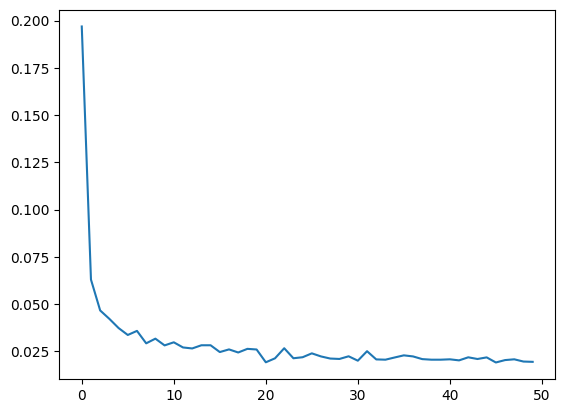

In [137]:
plt.plot(train_epoch_losses)

In [138]:
@torch.no_grad()
def generate_new_samples(epsilon_theta, diffuser, features, num_samples, diffusion_steps, device):
    random_noise_samples = torch.randn((num_samples, features, seq_len)).to(device)
    
    print(f"shape of random noise: {random_noise_samples.shape}")
    pbar = tqdm(iterable=reversed(range(0, diffusion_steps)))
    for i in pbar:
        pbar.set_description(f"SAMPLING STEP: {i:4d}")
        
        t = torch.full((num_samples,), i, dtype=torch.long).to(device)
        print(f"time step shape: {t.shape}")
        # print(f"Device random_noise_samples:{random_noise_samples.device}")
        # print(f"Device t:{t.device}")
        # print(f"Device model:{diffuser.device}")
        predicted_noise = epsilon_theta(random_noise_samples.float(), t) #num_samples, num_var, seq_len
        print(f"predicted_noise shape: {predicted_noise.shape}")
        z_norm = diffuser.reverse_process(predicted_noise, random_noise_samples, t)
        break
        
    return z_norm
    

In [139]:
new_data = generate_new_samples(epsilon_theta, diffuser, features=num_var, num_samples=100, diffusion_steps=200, device=device)
new_data = new_data.to("cpu")
#plt.plot(new_data)

shape of random noise: torch.Size([100, 1, 7])


SAMPLING STEP:  199: : 0it [00:00, ?it/s]

time step shape: torch.Size([100])
predicted_noise shape: torch.Size([100, 1, 7])
reverse process sqrt_alpha_t shape: torch.Size([100, 1])
reverse process betas_t shape: torch.Size([100, 1])
reverse process sqrt_one_minus_alpha_cumpord_t shape: torch.Size([100, 1])
reverse process epsilon_t shape: torch.Size([100, 1])
reverse process random_noise shape: torch.Size([100, 1, 7])
reverse process model_mean shape: torch.Size([100, 100, 7])
